In [1]:
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.sandbox.stats import runs
from sklearn.cluster import MeanShift,estimate_bandwidth
from sklearn.cluster import KMeans

In [2]:
def omit_outlier(data):
    y = data['实际电流']
    Q1 = np.percentile(y, 25)
    Q3 = np.percentile(y, 75)
    uplimit = Q3+1*(Q3-Q1)
    lowerlimit = Q1-1*(Q3-Q1)
    y_clean = y.copy()
#     y_clean = y_clean[y_clean>lowerlimit].reset_index(drop=True)
    return y_clean

def hampel_filter(Ia, k ,t0):
    y = Ia.copy()
    n = len(y)
    L = 1.4826
    for i in np.arange(k,n-k):
        y0 = np.median(y[(i-k):(i+k)])
        S0 = L * np.median(np.abs(y[(i-k):(i+k)]) - y0)
        if np.abs(y[i]-y0) > t0*S0:
            y[i] = y0
    #min max scale
    y_minmax = y.copy()
#     y_minmax = (y-y.min())/(y.max()-y.min())
    out = y_minmax.reset_index(drop=True)
    return out


In [3]:
# 简单波形
# data_all = pd.read_csv('/home/wrj/cal_num_python/mcj_data_0918.csv',encoding='gb2312')
data_all = pd.read_csv('/home/wrj/cal_num_python/train/摇臂钻床8D.csv',encoding='gb2312')
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2018-12-21摇臂钻床8D2018112700036.csv',encoding='gb2312')
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2018-12-21摇臂钻床7D2018112700037.csv',encoding='gb2312')
data_all = pd.read_csv('/home/wrj/cal_num_python/train/2H3ZTYWUN8Y1_20181226_c_摇臂钻床.csv',encoding='gb2312')
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2019-01-10摇臂钻床D2018092502556数据导出c.csv',encoding='gb2312')


# data_all = pd.read_csv('/home/wrj/cal_num_python/train/立式加工中心.csv',encoding='gb2312')

# 复杂波形
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2H3ZTYWVPTV1_20181226_c_卧式车床.csv',encoding='gb2312')
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/卧式车床4D.csv',encoding='gb2312') # 加了一个条件 if np.min(data)==0 不处理
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/焊机3071_D2018112700047.csv',encoding='gb2312')

# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2H3ZTYWVAE91_20181226_c_181226焊机.csv',encoding='gb2312')
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/焊机.csv',encoding='gb2312')# k=1



# yy
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2019-01-04武汉法利莱JKG9015激光切管机D2018092501402数据导出c.csv',encoding='gb2312')
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2019-01-08数控插齿机2D2018101200030数据导出c.csv',encoding='gb2312')
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2019-01-04数控铣齿机4D2018101200022数据导出c.csv',encoding='gb2312')

# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2019-01-09法利莱等离子切割机-发生器2M2018082800828数据导出c.csv',encoding='gb2312')
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2019-01-09拼板焊接专机 HP3000-P111213D2018092500874数据导出c.csv',encoding='gb2312')
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2019-01-09数控床身式铣床D2018092502570数据导出c.csv',encoding='gb2312')

data_all = pd.read_csv('/home/wrj/cal_num_python/train/2019-01-09数控卧式铣镗床D2018092502625数据导出c.csv',encoding='gb2312')
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2019-01-09数控卧式铣镗床D2018092502627数据导出c.csv',encoding='gb2312')
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2019-01-09数控铣齿机3D2018101200020数据导出.csv',encoding='gb2312')

# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2019-01-09双面对置式落地铣镗床D2018092502649数据导出c.csv',encoding='gb2312')
# data_all = pd.read_csv('/home/wrj/cal_num_python/train/2019-01-09镗床D2018092503402数据导出.csv',encoding='gb2312')


data_all = data_all.rename(columns={'A相电流(Ia)':'实际电流'})
data = data_all.dropna().reset_index()
Ia = data['实际电流']

In [4]:
%%time
k = 500
Ia_clean = omit_outlier(data)
Ia_ham = hampel_filter(Ia_clean, k, 3)  #k是一个超参数 表示左右多少的点计算滤波 


CPU times: user 41.9 s, sys: 4.06 s, total: 46 s
Wall time: 46 s


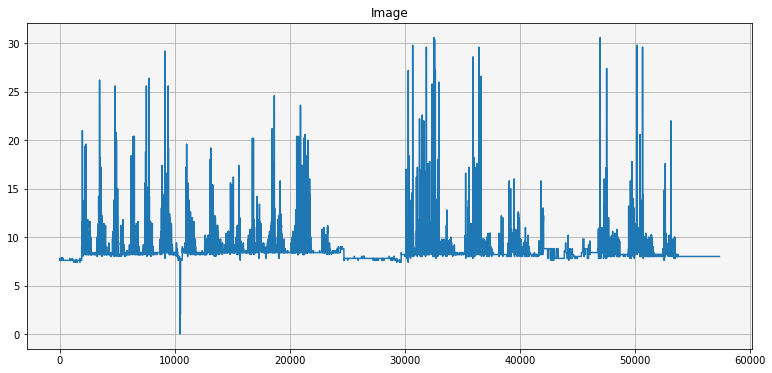

In [5]:
plt.rcParams['axes.facecolor'] = 'whitesmoke'
fig = plt.figure(figsize=(13,6))
plt.plot(data_all['实际电流'])
plt.title("Image",size=12)
plt.grid(True)

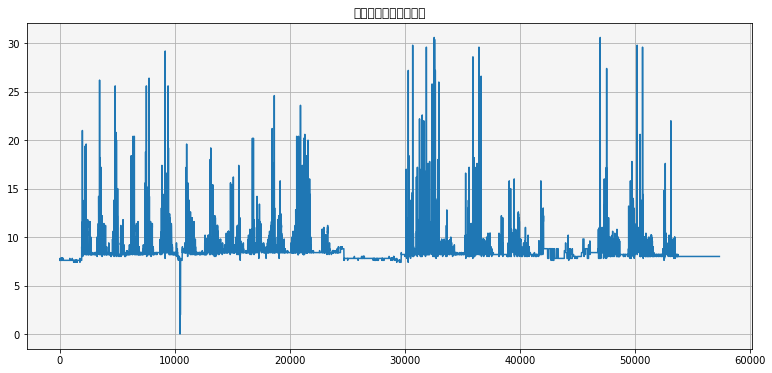

In [6]:
fig = plt.figure(figsize=(13,6))
plt.plot(Ia_clean)
plt.title("只删除异常值后的作图")
plt.grid(True)

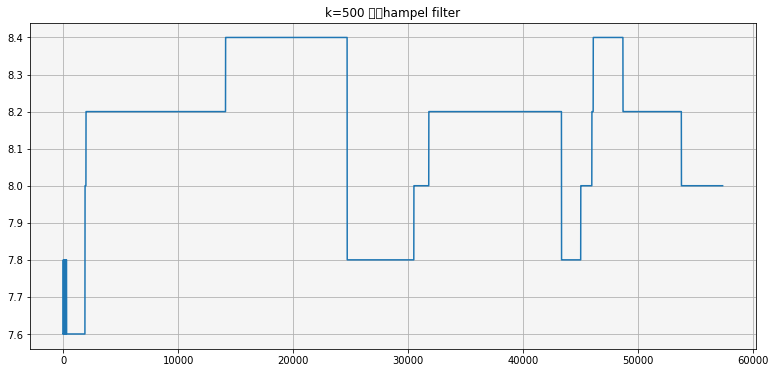

In [7]:
fig = plt.figure(figsize=(13,6))
plt.plot(Ia_ham)
plt.title("k=%s 时的hampel filter" % k )
plt.grid(True)

### 2. 根据差分值较大的前80个点（状态点）


In [8]:
def cal_diff(thre,area_var,need_Ia_diff_pos):
#     thre = 80 #40
#     area_var = 5*60
#     need_Ia_diff_pos = False
    Ia_diff1 = pd.Series(np.diff(Ia_ham))
    if need_Ia_diff_pos:
        Ia_diff1_sort = Ia_diff1.sort_values(ascending=False).reset_index(drop=True)
        thre_limit = Ia_diff1_sort[thre-1]
#         _,_,p=sns.kdeplot(Ia_diff1)
        Ia_diff1_great = Ia_diff1[Ia_diff1>thre_limit]
    else:
        Ia_diff1_sort = Ia_diff1.sort_values(ascending=True).reset_index(drop=True)
        thre_limit = Ia_diff1_sort[thre-1]
        Ia_diff1_great = Ia_diff1[Ia_diff1<thre_limit]
    #     Ia_diff1_sort = (-Ia_diff1).sort_values(ascending=False).reset_index(drop=True)
    #     thre_limit = Ia_diff1_sort[thre-1]
    #     Ia_diff1_great = Ia_diff1[Ia_diff1>thre_limit]
    mutation_point = Ia_diff1_great.index.values 

    var_c_list_all = []
    var_c_list = []
    mutation_list = []
    for no, cur_mutation_point in enumerate(mutation_point):
        left_boundary = max(0, cur_mutation_point-area_var)  # 太靠左边可能会有错误 因为样本半径内不足
        right_boundary = min(len(Ia_ham), cur_mutation_point+area_var)  #太靠右边可能会有错误 因为样本半径内不足
        left_data = Ia_ham[left_boundary:cur_mutation_point]
        right_data = Ia_ham[cur_mutation_point:right_boundary]   
        left_var = np.var(left_data)
        right_var = np.var(right_data)
        # mean
        left_mean = np.mean(left_data)
        right_mean = np.mean(right_data)
        # 判断
        if need_Ia_diff_pos:
            if left_var == 0:
                print("no=%s:左边的方差为0，出现异常" % no)
                left_var = 1e-4
                var_c = right_var/left_var
            var_c = right_var/left_var
            var_c_list_all.append(var_c)
            if left_mean<right_mean:  # 在var_c 较大的基础上 再增加一个 均值的判断条件
                var_c_list.append(var_c)
                mutation_list.append(cur_mutation_point)
        else:
            if right_var == 0:
                print("no=%s:右边的方差为0，出现异常" % no)
                right_var = 1e-4
                var_c = left_var/right_var
            var_c = left_var/right_var
    #         print("location",cur_mutation_point)
    #         print("left_var", left_var)
    #         print("right_var", right_var)
    #         print("var_c",left_var/right_var)
            var_c_list_all.append(var_c)
            if left_mean>right_mean:  # 在var_c 较大的基础上 再增加一个 均值的判断条件
                var_c_list.append(var_c)
                mutation_list.append(cur_mutation_point)
        var_c_np = np.array(var_c_list)
        mutation_np = np.array(mutation_list)

    score_var_c = pd.DataFrame({"mutation_point":mutation_np, "var_c":var_c_np}).sort_values(by="var_c",ascending=False).reset_index(drop=True)
    score_var_c_all = pd.DataFrame({"all_var_c":var_c_list_all,"mutation_point":mutation_point})
    if need_Ia_diff_pos:
        left_mutation = score_var_c.copy()
        return left_mutation
    else:
        right_mutation = score_var_c.copy()
        return right_mutation

left_mutation = cal_diff(80,300,True)
right_mutation = cal_diff(80,300,False)


no=0:左边的方差为0，出现异常
no=54:左边的方差为0，出现异常
no=55:左边的方差为0，出现异常
no=60:左边的方差为0，出现异常
no=61:左边的方差为0，出现异常
no=66:左边的方差为0，出现异常
no=67:左边的方差为0，出现异常


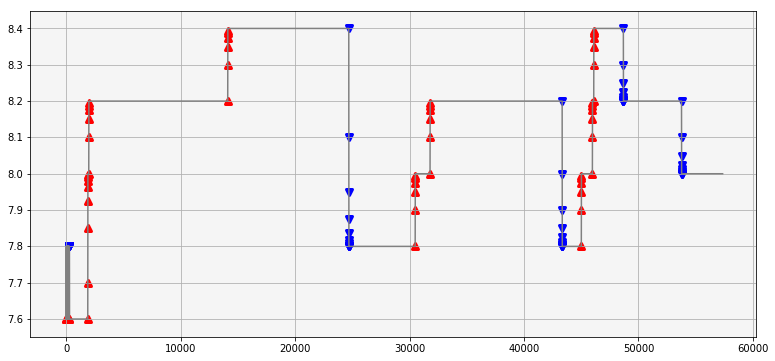

In [9]:
# draw_score = score_var_c.copy()
fig = plt.figure(figsize=(13,6))
plt.plot(Ia_ham, c='grey')
index_var_left = left_mutation['mutation_point']
plt.scatter(index_var_left,Ia_ham[index_var_left],marker='^',c='red',linewidths=3)
index_var_right = right_mutation['mutation_point']
plt.scatter(index_var_right,Ia_ham[index_var_right],marker='v',c='blue',linewidths=3)
plt.grid(True)

##### 3. 筛选策略1：var_c

In [10]:
right_mutation = right_mutation.loc[right_mutation['var_c']>1].reset_index(drop=True)
left_mutation = left_mutation.loc[left_mutation['var_c']>10].reset_index(drop=True)

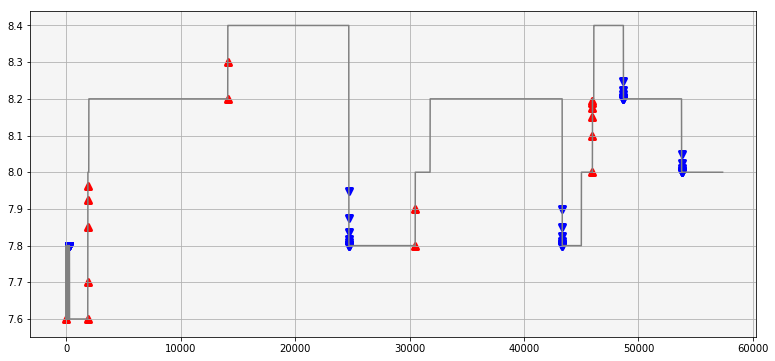

In [11]:
# draw_score = score_var_c.copy()
fig = plt.figure(figsize=(13,6))
plt.plot(Ia_ham, c='grey')
index_var_left = left_mutation['mutation_point']
plt.scatter(index_var_left,Ia_ham[index_var_left],marker='^',c='red',linewidths=3)
index_var_right = right_mutation['mutation_point']
plt.scatter(index_var_right,Ia_ham[index_var_right],marker='v',c='blue',linewidths=3)
plt.grid(True)

##### 4.筛选策略2：窗口过滤冗余点，取窗口内var_c最大原则

In [12]:
K =2*k
window = right_mutation['mutation_point']//K
right_mutation['window'] = window
right_mutation = right_mutation.sort_values(by=['window','var_c'],ascending=[True,False])
right_mutation_filter = pd.DataFrame(right_mutation.groupby(['window']).first()).reset_index(drop=True)
# right_mutation_filter

In [13]:
window = left_mutation['mutation_point']//k
left_mutation['window'] = window
left_mutation = left_mutation.sort_values(by=['window','var_c'],ascending=[True,False])
left_mutation_filter = pd.DataFrame(left_mutation.groupby(['window']).first()).reset_index(drop=True)
# left_mutation_filter

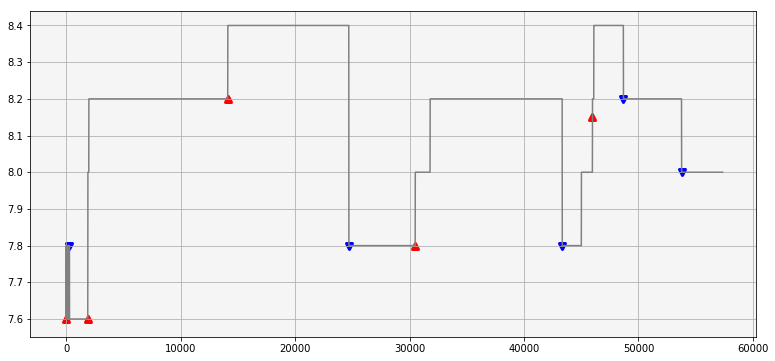

In [14]:
# draw_score = score_var_c.copy()
fig = plt.figure(figsize=(13,6))
plt.plot(Ia_ham, c='grey')
index_var_left = left_mutation_filter['mutation_point']
plt.scatter(index_var_left,Ia_ham[index_var_left],marker='^',c='red',linewidths=3)
index_var_right = right_mutation_filter['mutation_point']
plt.scatter(index_var_right,Ia_ham[index_var_right],marker='v',c='blue',linewidths=3)
plt.grid(True)

In [15]:
left_mutation_filter

,mutation_point,var_c
0,4,8.400000e+01
1,1891,5.805905e+24
2,14118,1.394416e+25
3,30494,8.924260e+24
4,45977,2.873946e+02


##### 5. 筛选策略3：确保两点之间的唯一性

In [16]:
#（1）获取游程，左右边界集合
left_mutation_filter["code"] = 1
right_mutation_filter["code"] = 0
all_mutation_filter = pd.concat([left_mutation_filter, right_mutation_filter], axis=0).sort_values(by="mutation_point", ascending=True).reset_index(drop=True)
all_mutation_filter['Ia_raw'] = Ia.values[all_mutation_filter["mutation_point"]]
code = all_mutation_filter["code"].values
mutation = all_mutation_filter['mutation_point'].values
v1 = mutation.copy()
code_diff = np.diff(code,n=1)
# 处理游程不等于1的点集合
state_run = runs.Runs(code)
run_df = pd.DataFrame({'idx':state_run.runstart[:-1],'len':state_run.runs})
# mutation_delete = set(range(len(all_mutation_filter)))&set(run_df.idx)
tmp_Ia_raw = all_mutation_filter["Ia_raw"]
mutation_loc_unique = []
idx_unique = []
for i in range(len(run_df)):
    start = run_df.loc[i,'idx']
    end = run_df.loc[i,'idx']+run_df.loc[i,'len']
    idxmin_ = tmp_Ia_raw[start:end].idxmin()
    mutation_loc_unique.append(all_mutation_filter.loc[idxmin_,"mutation_point"])
#     idx_unique.append(i)
mutation_loc_unique = pd.DataFrame({"mutation_point":mutation_loc_unique})  # 确保为左右端点一一对应关系
all_mutation_unique = all_mutation_filter.merge(mutation_loc_unique,on='mutation_point',how='inner')
# all_mutation_unique
left_mutation_unique = all_mutation_unique.loc[all_mutation_unique["code"]==1].reset_index(drop=True)
right_mutation_unique = all_mutation_unique.loc[all_mutation_unique["code"]==0].reset_index(drop=True)
left_unique_bound = left_mutation_unique['mutation_point']
right_unique_bound = right_mutation_unique['mutation_point']

Text(0.5, 1.0, 'Results')

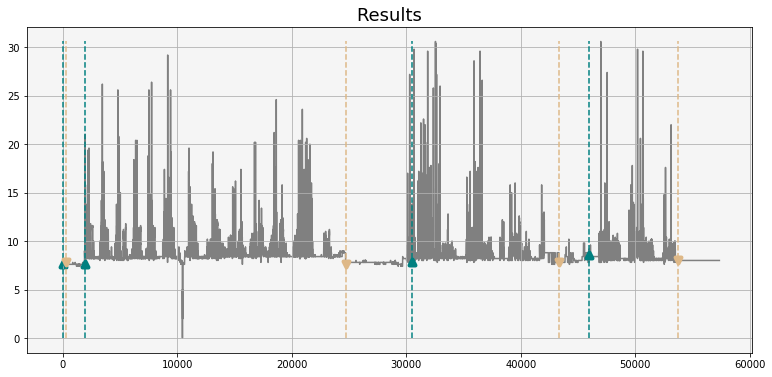

In [17]:
plt.rcParams['axes.facecolor'] = 'whitesmoke'
fig = plt.figure(figsize=(13,6))
plt.plot(Ia, c='grey',zorder=-5)
plt.scatter(left_unique_bound,Ia[left_unique_bound],marker='^',c='teal',linewidths=4,zorder=1)
plt.vlines(x=left_unique_bound,ymin = Ia.min(),ymax=Ia.max(),linestyles='dashed',colors="teal")
plt.grid(True,zorder=-6)
plt.scatter(right_unique_bound,Ia[right_unique_bound],marker='v',c='burlywood',linewidths=4,zorder=2)
plt.vlines(x=right_unique_bound,ymin = Ia.min(),ymax=Ia.max(),linestyles='dashed',colors="burlywood")
plt.title("Results",size=18)

6.筛选策略4：删除处于工作状态的“状态点”

In [18]:
# （2）筛选状态点
def get_standby(data):
    """
    判断最大值和最小值之间是否差20倍，如果差距过大，则进行筛选，否则不筛选
    """
    data = data.sort_values(ascending=True)
    if data[0]==0:  # 基本全为0的情况不筛选  可以根据需要筛选
        return data.reset_index(drop=False)
    elif np.max(data)/(np.min(data)+0.01) >20: #20 2.69 0.1  # 有些情况不需要筛选状态点
        print(np.max(data)/(np.min(data)+0.0001))
        print(np.max(data))
        uplimit = np.percentile(data,75)
        downlimit = np.percentile(data,25)
        limit = uplimit + (uplimit-downlimit)
        out = data[data<limit].reset_index(drop=False)
        return out
    else:
        return data.reset_index(drop=False)

In [19]:
#1 根据电流值聚类得出正常范围的点
# Ia_raw_table_left = left_mutation_unique.loc[left_mutation_unique["mutation_point"]==left_unique_bound.values,"Ia_raw"]
Ia_raw_table_left = left_mutation_unique.loc[:,"Ia_raw"]
Ia_raw_table_left_standby = get_standby(Ia_raw_table_left)
index_left_standby = Ia_raw_table_left_standby["index"]
# 获得正常范围内的点的dataframe
left_mutation_unique_better = left_mutation_unique.loc[index_left_standby,:].sort_values(by="mutation_point").reset_index(drop=True)
left_unique_bound_better = left_mutation_unique_better["mutation_point"]

In [20]:
#1 根据电流值聚类得出正常范围的点
Ia_raw_table_right = right_mutation_unique.loc[:,"Ia_raw"]
Ia_raw_table_right_standby = get_standby(Ia_raw_table_right) 
index_right_standby = Ia_raw_table_right_standby["index"]
#2 获得正常范围内的点的dataframe
right_mutation_unique_better = right_mutation_unique.loc[index_right_standby,:].sort_values(by="mutation_point").reset_index(drop=True)
right_unique_bound_better = right_mutation_unique_better["mutation_point"]

Text(0.5, 1.0, 'Results')

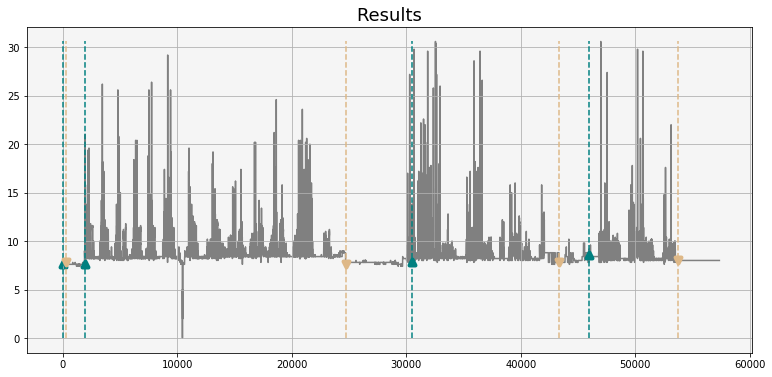

In [21]:
plt.rcParams['axes.facecolor'] = 'whitesmoke'
fig = plt.figure(figsize=(13,6))
plt.plot(Ia, c='grey',zorder=-5)
index_var_left = left_unique_bound_better.values
plt.scatter(index_var_left,Ia[index_var_left],marker='^',c='teal',linewidths=4,zorder=1)
plt.vlines(x=index_var_left,ymin = Ia.min(),ymax=Ia.max(),linestyles='dashed',colors="teal")
plt.grid(True,zorder=-6)
index_var_right = right_unique_bound_better.values
plt.scatter(index_var_right,Ia[index_var_right],marker='v',c='burlywood',linewidths=4,zorder=2)
plt.vlines(x=index_var_right,ymin = Ia.min(),ymax=Ia.max(),linestyles='dashed',colors="burlywood")
plt.title("Results",size=18)


##### 7.修正策略1：确保左右边界数量一样多

In [22]:
left_unique_bound_len = left_unique_bound_better.copy()
right_unique_bound_len = right_unique_bound_better.copy()
len_left = len(left_unique_bound_len)
len_right = len(right_unique_bound_len)
len_Ia = len(Ia)
if len_left<len_right:
    left_unique_bound_len = pd.Series(np.insert(np.array(left_unique_bound_len),0,0)) # 补充起始点
elif len_left>len_right:
    right_unique_bound_len = right_unique_bound_len.append(pd.Series([len(Ia)]),ignore_index=True)  # 补充末位点
else:
    if left_unique_bound_len[0]>right_unique_bound_len[0]:  # 左端点起始点大于右端点起始点
        left_unique_bound_len = np.insert(np.array(left_unique_bound_len),0,0)
        right_unique_bound_len = np.append(np.array(right_unique_bound_len),len(Ia))

    

Text(0.5, 1.0, 'Results')

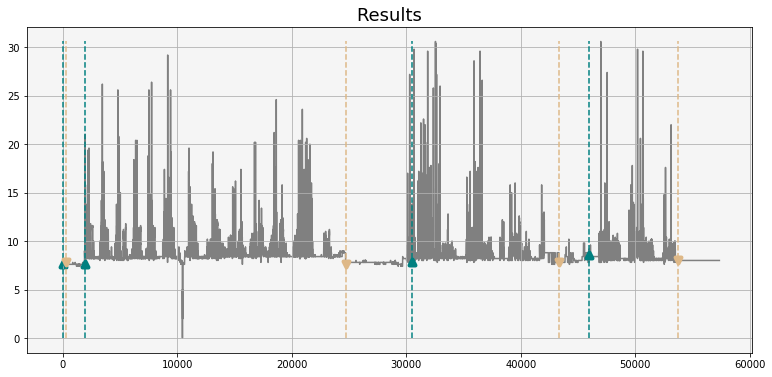

In [23]:
plt.rcParams['axes.facecolor'] = 'whitesmoke'
fig = plt.figure(figsize=(13,6))
plt.plot(Ia, c='grey',zorder=-5)
plt.scatter(left_unique_bound_len,Ia[left_unique_bound_len],marker='^',c='teal',linewidths=4,zorder=1)
plt.vlines(x=left_unique_bound_len,ymin = Ia.min(),ymax=Ia.max(),linestyles='dashed',colors="teal")
plt.grid(True,zorder=-6)
plt.scatter(right_unique_bound_len,Ia[right_unique_bound_len],marker='v',c='burlywood',linewidths=4,zorder=2)
plt.vlines(x=right_unique_bound_len,ymin = Ia.min(),ymax=Ia.max(),linestyles='dashed',colors="burlywood")
plt.title("Results",size=18)

Text(0.5, 1.0, 'Results by General Method')

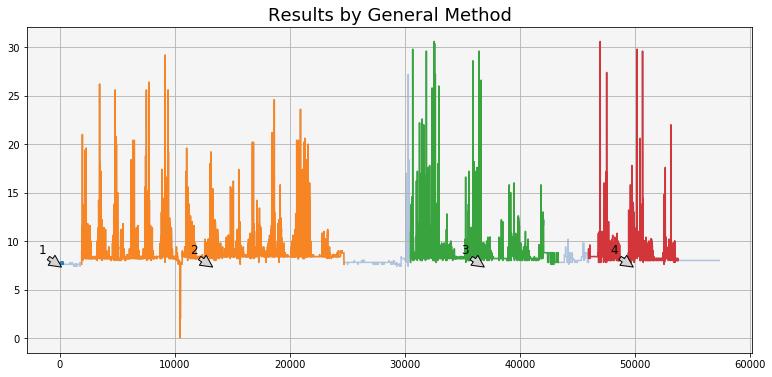

In [24]:
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.close('all')
fig = plt.figure(figsize=(13,6),facecolor="w",edgecolor="w")
plt.plot(Ia,color='lightsteelblue',zorder=1)
rounds = min(len(left_unique_bound_len),len(right_unique_bound_len))
for idx in range(rounds):
    start = left_unique_bound_len[idx]
    end = right_unique_bound_len[idx]
    cur_Ia = Ia[start:end]
    plt.plot(cur_Ia, alpha=0.9,zorder=2)
#     plt.vlines(x=start,ymin=Ia_ham.min(),ymax=Ia_ham.max(),colors='blue',linestyles=':', zorder=layer,label='Data samples:%s' %layer)
#     plt.vlines(x=end,ymin=Ia_ham.min(),ymax=Ia_ham.max(),colors='red',linestyles=':', zorder=layer,label='Data samples:%s' %layer)
    arrow_idx = (start+end)/2
    plt.annotate('%s' % (idx+1), xy=(arrow_idx, max(Ia_ham)*0.87), xytext=(arrow_idx-2000, max(Ia_ham)),size=12,
      arrowprops=dict(facecolor='lightgray', shrink=0.01),zorder=2 ,horizontalalignment='left',verticalalignment='bottom')
plt.grid(True, zorder=-6)
plt.title("Results by General Method",size=18)



##### 状态识别

In [25]:
wave_len = right_unique_bound_len-left_unique_bound_len
work_table = pd.DataFrame({"start_idx":left_unique_bound_len,"end_idx":right_unique_bound_len,"wave_len":wave_len})
work_start_idx = work_table["start_idx"].values
work_end_idx = work_table["end_idx"].values

state_summary_table = pd.DataFrame({"Ia":Ia, "state":"standby"})
for i in range(len(work_start_idx)):
    state_summary_table.loc[work_start_idx[i]:work_end_idx[i],"state"] = "work"
state_summary_table.loc[state_summary_table["Ia"] == 0,"state"] = "stop"
# state_summary_table["draw"] = 0


In [ ]:
from plotnine import *
state_summary_table_plot = state_summary_table.reset_index(drop=False)
state_summary_table_plot = state_summary_table_plot.rename(columns={"index":"time","Ia":"Ia","state":"state"})
state_summary_table_plot.loc[(len(state_summary_table_plot)-1),"Ia"] =0 
p=(ggplot(state_summary_table_plot,aes(x='time',y='Ia',color='state')) 
   + geom_point(size=0.1) 
   + theme_bw()
   + ggtitle("State Recognition by General Method")+theme(figure_size=(13,6))
   + scale_color_manual(values=[ 'teal', 'burlywood','cornflowerblue'])
#    + scale_color_manual(values=['#939c49', '#6d6e71', '#ea9f2f'])
  )
p


##### 9.修正策略2：剔除短暂工作状态

In [ ]:
K1 = 300
wave_len = right_unique_bound_len-left_unique_bound_len
state_table = pd.DataFrame({"start_idx":left_unique_bound_len,"end_idx":right_unique_bound_len,"wave_len":wave_len})
state_table_filter = state_table.loc[state_table["wave_len"]>K1,:].reset_index(drop=True)

In [ ]:
left_unique_bound_filter = state_table_filter["start_idx"]
right_unique_bound_filter = state_table_filter["end_idx"]
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.close('all')
fig = plt.figure(figsize=(13,6),facecolor="w",edgecolor="w")
plt.plot(Ia,color='lightsteelblue',zorder=1)
rounds = min(len(left_unique_bound_filter),len(right_unique_bound_filter))
for idx in range(rounds):
    start = left_unique_bound_filter[idx]
    end = right_unique_bound_filter[idx]
    cur_Ia = Ia[start:end]
    plt.plot(cur_Ia, alpha=0.9,zorder=2)
#     plt.vlines(x=start,ymin=Ia_ham.min(),ymax=Ia_ham.max(),colors='blue',linestyles=':', zorder=layer,label='Data samples:%s' %layer)
#     plt.vlines(x=end,ymin=Ia_ham.min(),ymax=Ia_ham.max(),colors='red',linestyles=':', zorder=layer,label='Data samples:%s' %layer)
    arrow_idx = (start+end)/2
    plt.annotate('%s' % (idx+1), xy=(arrow_idx, max(Ia_ham)*0.87), xytext=(arrow_idx-2000, max(Ia_ham)),size=12,
      arrowprops=dict(facecolor='lightgray', shrink=0.01),zorder=2 ,horizontalalignment='left',verticalalignment='bottom')
plt.grid(True, zorder=-6)
plt.title("Results by Simple Method",size=18)
